# Pairs Trading Strategy on KOTAKBANK and HDFCBANK

##What is Pairs Trading?

Pairs trading is a market-neutral trading strategy that seeks to exploit price discrepancies between two highly correlated assets.

It involves:

1. Selecting two assets that have a strong historical correlation.
2. Buying the asset that is currently undervalued and selling the asset that is currently overvalued.
3. Closing the positions when the price discrepancy between the two assets reverts to its historical norm.

Pairs trading is a relatively low-risk strategy, as it is not dependent on the overall market direction. However, it can be difficult to identify pairs of assets that are suitable for trading.

In [2]:
#importing libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
#downloading data from yfinance api
end = '2024-12-31'
start = '2019-1-1'
#downloading icicibank and axisbank last 7 years close prices from yfinance
x = yf.download('KOTAKBANK.NS',start,end)['Adj Close']
y = yf.download('HDFCBANK.NS',start,end)['Adj Close']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
df = pd.concat([x,y],axis=1)
df.columns = ['KOTAKBANK','HDFCBANK']
# df.index = pd.to_datetime(df.index)
df

,KOTAKBANK,HDFCBANK
Date,,
2019-01-01,1247.377319,1036.382324
2019-01-02,1237.551514,1026.926147
2019-01-03,1232.214722,1018.868774
2019-01-04,1244.883545,1021.594666
2019-01-07,1243.536743,1023.138550
...,...,...
2024-04-16,1792.599976,1509.250000
2024-04-18,1786.750000,1494.699951
2024-04-19,1792.650024,1531.300049


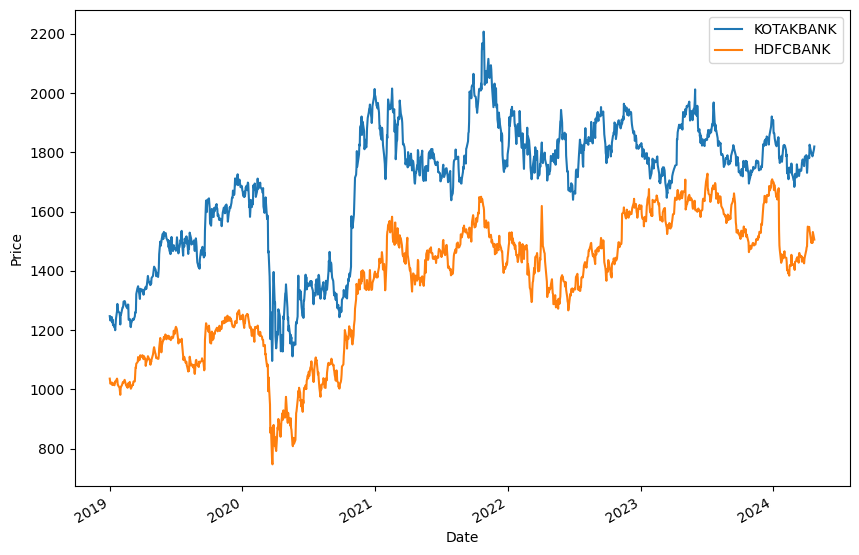

In [5]:
df.plot(figsize=(10,7))
plt.ylabel("Price")
plt.show()

> Upon initial observation of the charts, it appears that there is a correlation in the prices of both stocks. However, before proceeding, it is imperative to conduct further investigation to determine whether these stocks are indeed suitable candidates for the pairs trading strategy.

# We're employing linear regression to determine the relationship between the prices of HDFC Bank ('HDFCBANK') and Kotak Mahindra Bank ('KOTAKBANK'). This analysis yields the hedge ratio, indicating the degree of co-movement between the two stocks. A higher hedge ratio implies a stronger correlation, which is essential for constructing a viable pairs trading strategy.

In [8]:
'''
Performing linear regression between HDFC Bank ('HDFCBANK') and Kotak Mahindra Bank ('KOTAKBANK')
prices using np.polyfit(). The resulting slope represents the hedge ratio,
indicating how much of Kotak Mahindra Bank we need to long/short against one unit of HDFC Bank in pairs trading.

'''

X = df['HDFCBANK']
y = df['KOTAKBANK']

model = np.polyfit(X,y,deg=1)
hedge_ratio = model[0]
hr = round(hedge_ratio,3)
print(f'The hedge ratio is {hr}')

The hedge ratio is 0.908


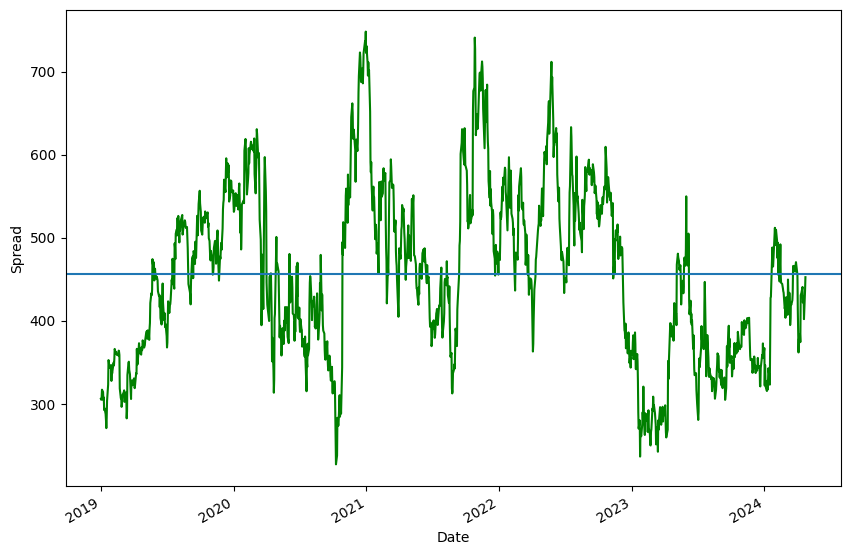

In [9]:
'''
Calculating and plotting the spread between 'KOTAKBANK' and 'HDFCBANK'
prices, adjusted by the hedge ratio. This spread visualization aids in
identifying trading opportunities based on price differentials.

'''

df['spread'] = df.KOTAKBANK - hr * df.HDFCBANK

# Plot the spread
df.spread.plot(figsize=(10,7), color='g')
plt.axhline(df.spread.mean())
plt.ylabel("Spread")

plt.show()

# Cointegration

####Cointegration is a unique form of correlation between two time series, where their ratio fluctuates around a mean value. In pairs trading, cointegration is essential as it ensures the ratio between assets converges to a stable mean over time, validating the strategy's effectiveness.


##Testing for Cointegration

In the statsmodels.tsa.stattools library, there's a convenient test for cointegration. Given that we've artificially constructed two highly cointegrated series, we expect to observe an extremely low p-value from this test.

In [15]:
"""
Using the Augmented Dickey-Fuller (ADF) test from statsmodels.tsa.stattools
to assess the stationarity of the 'spread' series. A low p-value indicates strong evidence
against non-stationarity, validating its suitability for pairs trading strategies.

"""
# Importing the ADF test function from statsmodels.tsa.stattools
from statsmodels.tsa.stattools import adfuller

# Applying the ADF test to the 'spread' series with a maximum lag of 1
adf_result = adfuller(df.spread, maxlag=1)

# Printing the ADF test results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

# Check if the spread series is stationary based on the p-value
if adf_result[1] < 0.05:
    print("The spread series is likely stationary.")
else:
    print("The spread series is likely not stationary.")

ADF Statistic: -4.15094591775702
p-value: 0.0007968566466692525
Critical Values: {'1%': -3.4353554773774553, '5%': -2.86375051023515, '10%': -2.5679468876340037}
The spread series is likely stationary.


#Spread-based Mean Reversion Strategy Function

This function calculates trading positions based on the spread, incorporating parameters such as the lookback period and standard deviation. It enables the implementation of a mean reversion trading strategy.

In [20]:
def mean_reversion_strategy(df, period, std_dev):
    """
    Computes trading positions based on the spread, using a mean reversion strategy with specified parameters.

    Parameters:
    - df: DataFrame containing spread data
    - period: Lookback period for calculating moving average and standard deviation
    - std_dev: Number of standard deviations to use for defining upper and lower bands

    Returns:
    - DataFrame with additional columns for positions based on the mean reversion strategy
    """

    # Moving Average
    df['moving_average'] = df.spread.rolling(period).mean()
    # Moving Standard Deviation
    df['moving_std_dev'] = df.spread.rolling(period).std()

    # Upper band and lower band
    df['upper_band'] = df.moving_average + std_dev * df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev * df.moving_std_dev

    # Long positions
    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average
    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.positions_long = df.positions_long.fillna(method='ffill')

    # Short positions
    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average
    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0
    df.positions_short = df.positions_short.fillna(method='ffill')

    # Combined positions
    df['positions'] = df.positions_long + df.positions_short

    return df

In [22]:
df = mean_reversion_strategy(df,30,1)
df.dropna(inplace=True)
df.tail(3)

,KOTAKBANK,HDFCBANK,spread,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,positions_long,short_entry,short_exit,positions_short,positions,percentage_change,strategy_returns,cumulative_returns
Date,,,,,,,,,,,,,,,,,
2024-04-19,1792.650024,1531.300049,402.229580,425.038799,30.040356,455.079155,394.998443,False,False,0.0,False,True,0.0,0.0,-0.008587,-0.0,1.678016
2024-04-22,1809.949951,1512.199951,436.872396,425.390932,30.117568,455.508500,395.273365,False,True,0.0,False,False,0.0,0.0,0.010884,0.0,1.678016
2024-04-23,1819.949951,1505.750000,452.728951,426.901625,30.320410,457.222035,396.581215,False,True,0.0,False,False,0.0,0.0,0.004975,0.0,1.678016


## Cumulative returns

In [18]:
df['percentage_change'] = (df.spread - df.spread.shift(1))/(hr*df.HDFCBANK + df.KOTAKBANK)
df['strategy_returns'] = df.positions.shift(1) * df.percentage_change
df['cumulative_returns'] = (df.strategy_returns+1).cumprod()
"The total strategy returns are %.2f" % ((df['cumulative_returns'].iloc[-1]-1)*100)

'The total strategy returns are 67.80'

In [24]:
# Calculating the Sharpe ratio of the strategy
sharpe_ratio = (df['strategy_returns'].mean() * 252) / (df['strategy_returns'].std() * np.sqrt(252))

# Printing the Sharpe ratio with 3 decimal places
print(f'Sharpe Ratio: {np.round(sharpe_ratio, 3)}')


Sharpe Ratio: 0.928


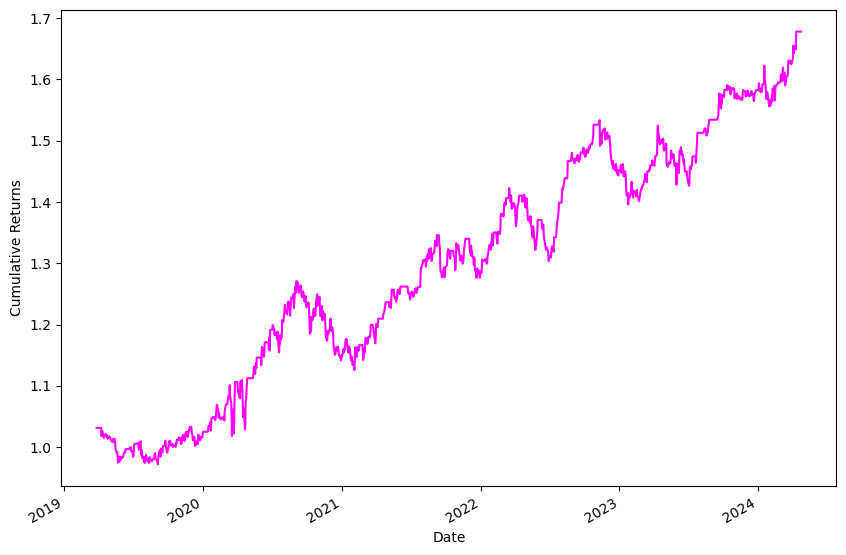

In [25]:
#plotting the cumulative returns of the strategy
df.cumulative_returns.plot(label='Returns', figsize=(10,7),color='magenta')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

###DRWADOWN FUNCTION

The maximum drawdown is -11.40


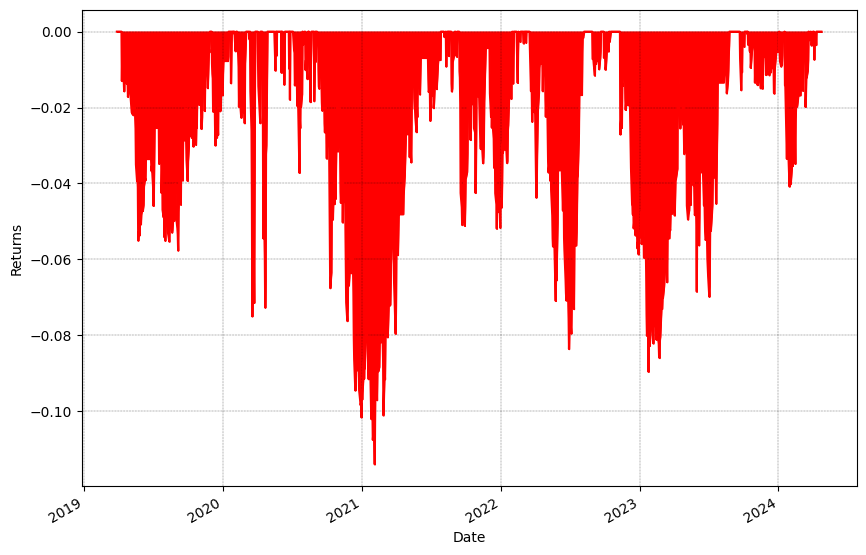

In [26]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(10, 7))
    # Plot
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()

drawdown_strategy = calc_drawdown(df.cumulative_returns)
print("The maximum drawdown is %.2f" % (drawdown_strategy.min()*100))
plot_drawdown(drawdown_strategy)

[*********************100%%**********************]  1 of 1 completed


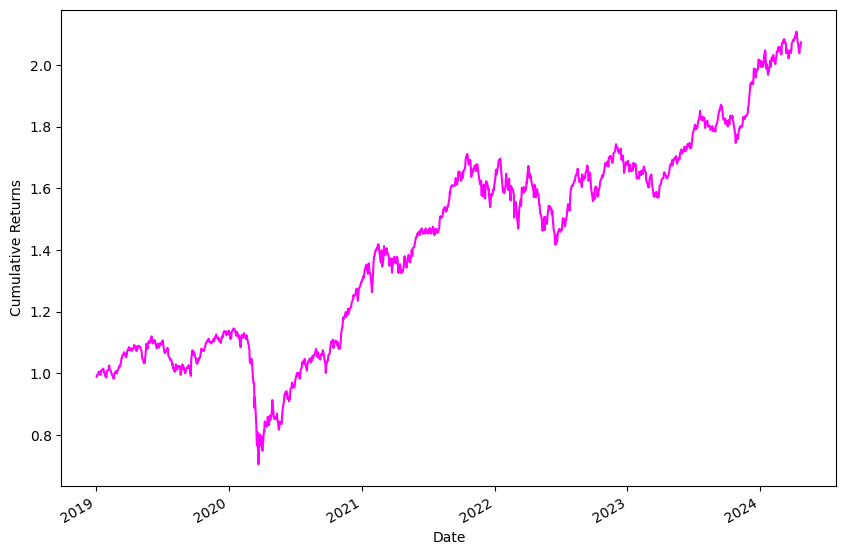

Date
2019-01-02    10792.500000
2019-01-03    10672.250000
2019-01-04    10727.349609
2019-01-07    10771.799805
2019-01-08    10802.150391
                  ...     
2024-04-16    22147.900391
2024-04-18    21995.849609
2024-04-19    22147.000000
2024-04-22    22336.400391
2024-04-23    22379.900391
Name: Adj Close, Length: 1307, dtype: float64

In [27]:
#to compare how our strategy performed , we will create an instance and compare the drawdown
start_date = '2019-01-01'
end_date = '2024-12-31'

nifty = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']
nifty.columns = ['Nifty']
nifty_cum_rets = (nifty.pct_change().dropna()+1).cumprod()
nifty_cum_rets.plot(label='Nifty', figsize=(10,7),color='magenta')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()
nifty

The maximum drawdown is -38.44


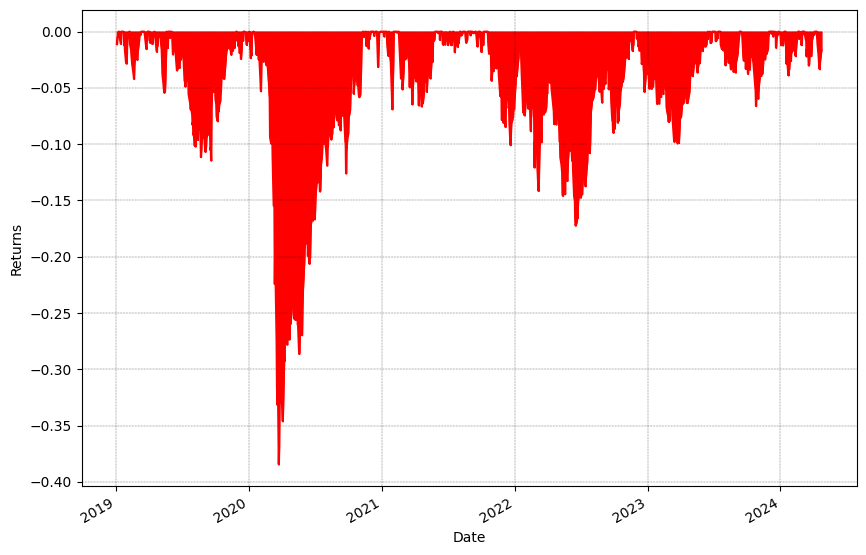

In [28]:
#drawdown_nifty
drawdown_nifty = calc_drawdown(nifty_cum_rets)
print("The maximum drawdown is %.2f" % (drawdown_nifty.min()*100))
plot_drawdown(drawdown_nifty)